# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
from sparse_field_lib import load_data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

from astropy.table import Table

In [4]:
%matplotlib inline

In [5]:
# import ipywidgets as widgets
# from ipywidgets import interact, interactive, fixed, interact_manual

# import plotly.express as px
# import plotly.graph_objects as go

In [6]:
# where is the sdss data? 
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'

In [7]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

## Utility Functions

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def imshow_cbar(fig, ax, image, vmin=None, vmax=None, s=20): 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(image, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=s)

# Load data

In [9]:
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=94,
    camcol=1,
    fields=(12,),
    bands=range(5),
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

In [10]:
frame, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)
frame_fits = Table(sdss_data[0]['po_fits'])
print("# objects detected by photo on frame: ", len(frame_fits))
print("# objects detected by photo on coadd: ", len(fits_file['ra'][:]))
frame = frame[0].numpy()
print(frame.shape)

# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901
(1489, 2048)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [11]:
wcs = wcs_list[0]
pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)
pt_frame, pr_frame = wcs.all_world2pix(frame_fits['RA'].reshape(-1), frame_fits['DEC'].reshape(-1), 0)
is_star = fits_file['probpsf'][:].astype(bool)

# remove all locations that are not inside the image. 
keep = (pt > 0) & (pt < frame.shape[1]-1) & (pr > 0) & (pr < frame.shape[0]-1)
pt = pt[keep]
pr = pr[keep]
is_star = is_star[keep]

keep_frame = (pt_frame > 1) & (pt_frame < frame.shape[1]-1) & (pr_frame > 1) & (pr_frame < frame.shape[0]-1)
pt_frame = pt_frame[keep_frame]
pr_frame = pr_frame[keep_frame]

In [12]:
def convert_mag_to_nmgy(mag):
    return 10**((22.5 - mag) / 2.5)

In [13]:
r_mag = fits_file['psfmag_r'][:][keep]

nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'].mean()

true_fluxes = convert_mag_to_nmgy(r_mag) * nelec_per_nmgy

(array([775.,  16.,   7.,   3.,   1.,   2.,   1.,   2.,   2.,   2.]),
 array([7.9994845e+00, 1.0457246e+05, 2.0913692e+05, 3.1370138e+05,
        4.1826584e+05, 5.2283031e+05, 6.2739475e+05, 7.3195925e+05,
        8.3652369e+05, 9.4108819e+05, 1.0456526e+06], dtype=float32),
 <BarContainer object of 10 artists>)

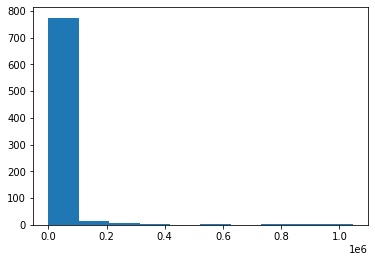

In [14]:
plt.hist(true_fluxes)

# Prepare model

In [15]:
# prepare BLISS model 
checkpoint_file = '/home/runingli/astronomy/celeste/models/sleep_sdss_measure.ckpt'
sleep_net= sleep.SleepPhase.load_from_checkpoint(checkpoint_file).to(device)
image_encoder = sleep_net.image_encoder
galaxy_encoder = sleep_net.galaxy_encoder

# important to turn on .eval() mode!
sleep_net = sleep_net.eval()
sleep_net.galaxy_encoder.eval()
image_encoder = image_encoder.eval()

In [16]:
# load flux model 

from bliss.models import flux_net
from hydra import initialize, compose

overrides = {'model':"sleep_sdss_measure_simple", 'dataset':'default'}
overrides = [f"{key}={value}" for key, value in overrides.items()]
with initialize(config_path="../../config"): # possibly change relative path to config folder here. 
    cfg = compose("config", overrides=overrides)
    
    
flux_checkpoint_file = '/home/runingli/astronomy/celeste/models/flux_net.ckpt'
flux_encoder = flux_net.FluxEstimator.load_from_checkpoint(flux_checkpoint_file, 
                                                           decoder_kwargs = cfg.model.kwargs.decoder_kwargs)
flux_encoder.eval();
flux_encoder.to(device);

# Loop over chunks

In [17]:
import numpy as np

In [18]:
import copy

h,w = frame.shape # full frame size.

cp = image_encoder.border_padding # chunk padding 
clen = 300 # chunk slen (square).
cplen = clen + cp*2 # padded chunk slen. 

ihic = h // clen # image height in chunks
iwic = w // clen # image width in chunks

locs = torch.tensor([])
galaxy_bool = torch.tensor([])
fluxes = torch.Tensor([])
fluxes2 = torch.Tensor([])

pt1 = copy.deepcopy(pt)
pr1 = copy.deepcopy(pr)

keep = np.zeros((len(pt1))).astype(bool)

with torch.no_grad():
    for i in range(iwic):
        for j in range(ihic):
            print(i,j)
            x1,y1 = i*clen + cp, j*clen + cp
            pchunk = frame[y1 - cp: y1 + clen + cp, x1 - cp: x1 + clen + cp]
            assert pchunk.shape == (cplen, cplen)
            pchunk = pchunk.astype(np.float32)
            pchunk = torch.from_numpy(pchunk).to(device).reshape(1, 1, cplen, cplen)
            
            # get estimates with BLISS trained model. 
            tile_est = sleep_net.tile_images_map_estimate(pchunk)
            est_params = encoder.get_full_params(tile_est, clen)
            
            # new estimates from flux encoder 
            flux_estimates = flux_encoder(pchunk)
            tile_est['fluxes'] = flux_estimates['mean']
            est_params2 = encoder.get_full_params(tile_est, clen)
            
            
            _locs = est_params['locs'].cpu()
            _galaxy_bool = est_params['galaxy_bool'].cpu().reshape(-1, 1)
            _fluxes = est_params['fluxes'].cpu().reshape(-1, 1)
            _fluxes2 = est_params2['fluxes'].cpu().reshape(-1, 1)
            
            _locs = _locs.reshape(-1, 2)
            x, y = _locs[:, 1].reshape(-1, 1), _locs[:, 0].reshape(-1, 1)
            x = x*clen + x1 - 0.5 
            y = y*clen + y1 - 0.5 # pixels, same format as pt,pr
            locs1 = torch.hstack((x,y)).reshape(-1, 2).cpu()
            locs  = torch.cat((locs, locs1))
            
            _galaxy_bool = _galaxy_bool.reshape(-1, 1)
            galaxy_bool = torch.cat((galaxy_bool, _galaxy_bool))
            
            fluxes = torch.cat((fluxes, _fluxes))
            fluxes2 = torch.cat((fluxes2, _fluxes2))
            
            # remove centroids from true photo in padding
            keep1 = (pt1 > x1) & (pt1 < x1+clen) & (pr > y1) & (pr < y1+clen)
            keep = keep | keep1

            # delete extra stuff in GPU and clear cache for next iteration.
            del pchunk
            del tile_est
            del est_params
            torch.cuda.empty_cache()

pt1, pr1 = pt1[keep], pr1[keep]
true_fluxes = true_fluxes[keep]
is_star1 = is_star[keep]

locs = locs.numpy()
galaxy_bool = galaxy_bool.numpy()
fluxes = fluxes.numpy()
fluxes2 = fluxes2.numpy()

print('done.')

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3
done.


In [19]:
# how many objects are left? 
print(len(pt1), len(locs))

536 423


# Match objects

In [20]:
from bliss.metrics import inner_join_locs
_plocs = torch.from_numpy(np.hstack((pt1.reshape(-1, 1), pr1.reshape(-1, 1))))
_locs = torch.from_numpy(locs)
_galaxy_bool = torch.from_numpy(galaxy_bool)

# do matching
_plocs, _locs, row_indx, col_indx = inner_join_locs(_plocs, _locs)

#only keep match if l_{inf} < 1 pixel away. 
dist = (_plocs - _locs).abs().max(1)[0]
keep_match = dist < 1.0

_plocs = _plocs[keep_match].numpy()
_locs = _locs[keep_match].numpy()

# need to apply it to galaxy bool as well.
_galaxy_bool = _galaxy_bool[col_indx][keep_match].reshape(-1).numpy().astype(bool)
_is_star = is_star1[row_indx][keep_match].reshape(-1).astype(bool)

_true_fluxes = true_fluxes[row_indx][keep_match].reshape(-1)
_fluxes = fluxes[col_indx][keep_match].reshape(-1)
_fluxes2 = fluxes2[col_indx][keep_match].reshape(-1)

In [21]:
def plot_scatter(truth, est, ax):
    
    ax.scatter(truth, est)
    ax.plot(est, est, color = 'red')
    
    ax.set_xlabel('truth')
    ax.set_ylabel('est')

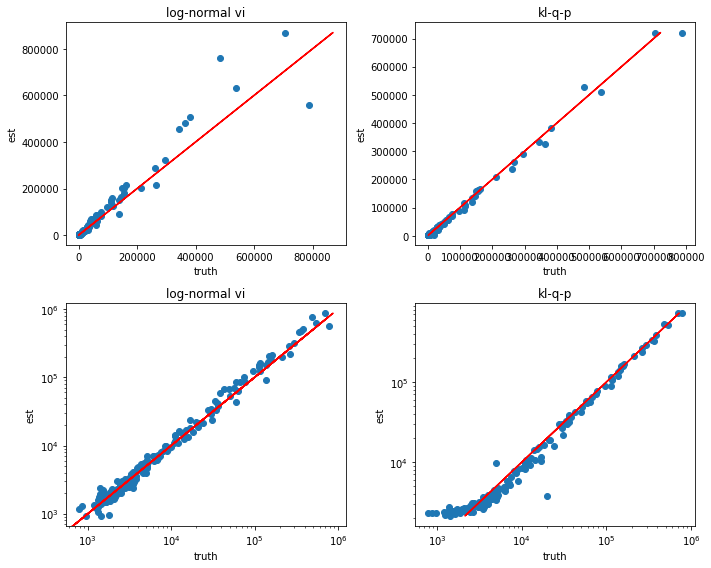

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))


# old method
for i in range(2): 
    plot_scatter(_true_fluxes[_is_star],
                 _fluxes[_is_star],
                 axes[i, 0])
    axes[i, 0].set_title('log-normal vi')

axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')

# new method
for i in range(2): 
    plot_scatter(_true_fluxes[_is_star],
                 _fluxes2[_is_star],
                 axes[i, 1])
    axes[i, 1].set_title('kl-q-p')

axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')


fig.tight_layout();

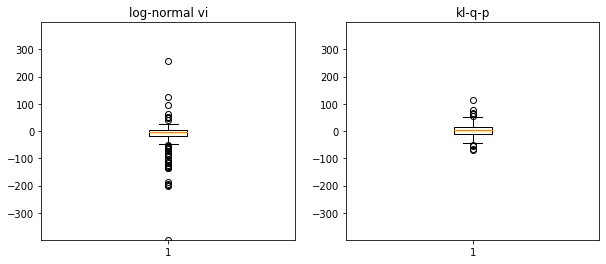

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

def get_diff(truth, est): 
    return ((truth - est) / np.sqrt(truth)).flatten()

res1 = get_diff(_true_fluxes[_is_star],
                _fluxes[_is_star])


res2 = get_diff(_true_fluxes[_is_star],
                _fluxes2[_is_star])

axes[0].set_title('log-normal vi')
axes[0].boxplot(res1);

axes[1].set_title('kl-q-p')
axes[1].boxplot(res2);

vmax = max(np.abs(res1).max(), np.abs(res2).max())

for i in range(2): 
    axes[i].set_ylim((-vmax, vmax))

# Check out residuals

In [204]:
def get_residuals(obs, recon): 
    return (obs - recon) / torch.sqrt(recon)

In [157]:
def plot_recon(obs, recon, ax1, ax2): 
        
    im1 = ax1.matshow(recon)
    fig.colorbar(im1, ax = ax1)
    
    # diff 
    res = get_residuals(obs, recon) 
    vmax = res.abs().max()

    im2 = ax2.matshow(res, 
                          cmap = plt.get_cmap('bwr'), 
                          vmax = vmax,
                          vmin = -vmax)
    fig.colorbar(im2, ax = ax2)
    
    fig.tight_layout()

In [175]:
def plot_flux_residuals(): 
    # sample a chunk 
    i = np.random.choice(iwic)
    j = np.random.choice(ihic)

    x1,y1 = i*clen + cp, j*clen + cp
    pchunk = frame[y1 - cp: y1 + clen + cp, x1 - cp: x1 + clen + cp]
    assert pchunk.shape == (cplen, cplen)
    pchunk = pchunk.astype(np.float32)
    pchunk = torch.from_numpy(pchunk).to(device).reshape(1, 1, cplen, cplen)

    with torch.no_grad():
        tile_est = sleep_net.tile_images_map_estimate(pchunk)

        recon = flux_encoder.image_decoder.render_images(
                    tile_est["n_sources"],
                    tile_est["locs"],
                    tile_est["galaxy_bool"],
                    tile_est["galaxy_params"],
                    tile_est['fluxes'], 
                    add_noise=False,
                )[0]


        est_params = encoder.get_full_params(tile_est, clen)


        # sample a star 
        star_bool = est_params['galaxy_bool'].squeeze() == 0
        locs = est_params['locs'].squeeze() * clen + cp - 0.5
        star_locs = locs[star_bool]
        which_star = np.random.choice(star_locs.shape[0])

        # get coordinates to center on this star
        s = 10
        x0 = int(star_locs[which_star][0] - s)
        x1 = int(star_locs[which_star][1] - s)

        obs = pchunk.cpu()[0, 0, x0:(x0+2*s), x1:(x1+2*s)]
        recon = recon.cpu()[0, 0, x0:(x0+2*s), x1:(x1+2*s)]

        # plot observed 
        fig, axes = plt.subplots(1, 5, figsize=(18,3))    
        im0 = axes[0].matshow(obs)
        fig.colorbar(im0, ax = axes[0])

        plot_recon(obs, recon, axes[1], axes[2])

        # reconstruction with new fluxe encoder 
        flux_est = flux_encoder(pchunk)
        recon2 = flux_encoder.image_decoder.render_images(
                    tile_est["n_sources"],
                    tile_est["locs"],
                    tile_est["galaxy_bool"],
                    tile_est["galaxy_params"],
                    flux_est['mean'], 
                    add_noise=False,
                )[0]

        recon2 = recon2.cpu()[0, 0, x0:(x0+2*s), x1:(x1+2*s)]
        plot_recon(obs, recon2, axes[3], axes[4])


Global seed set to 2323


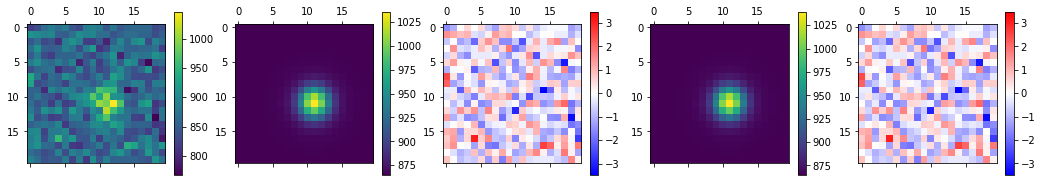

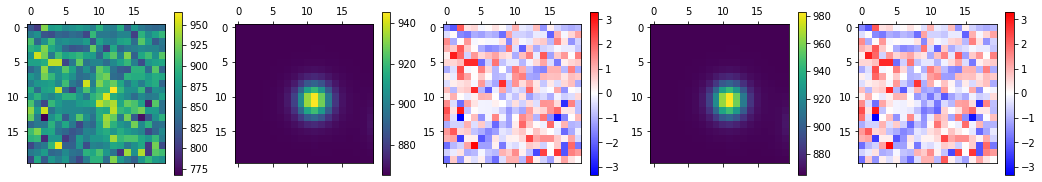

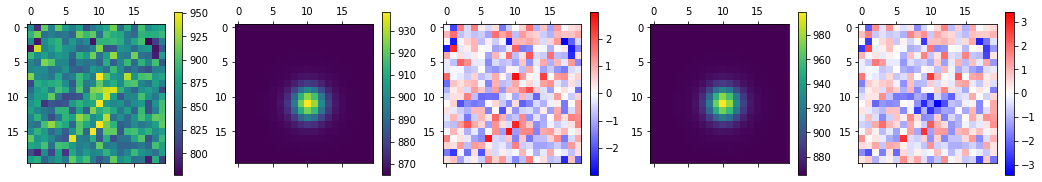

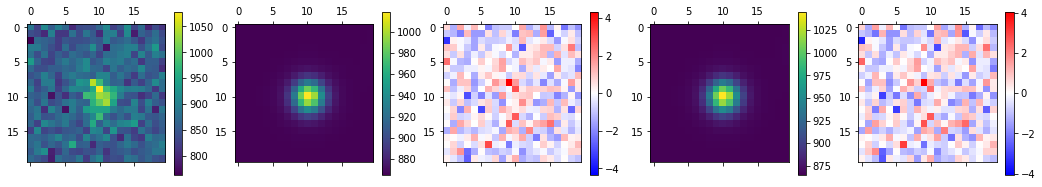

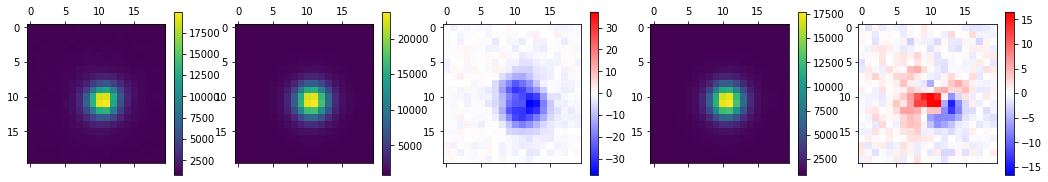

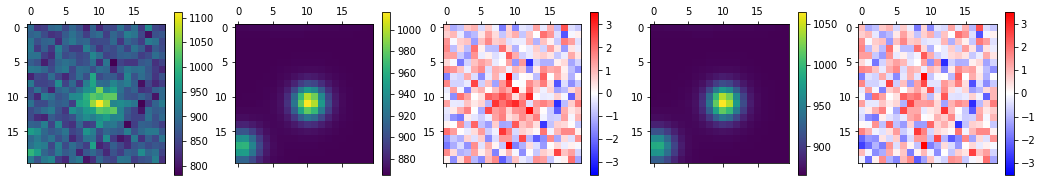

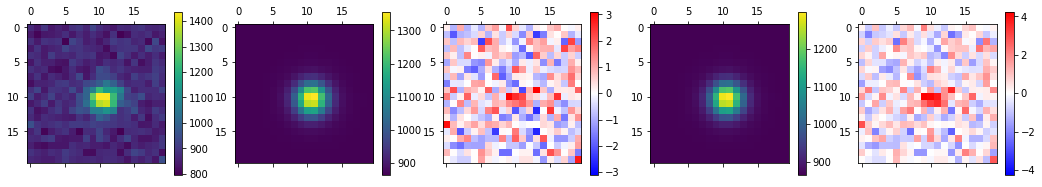

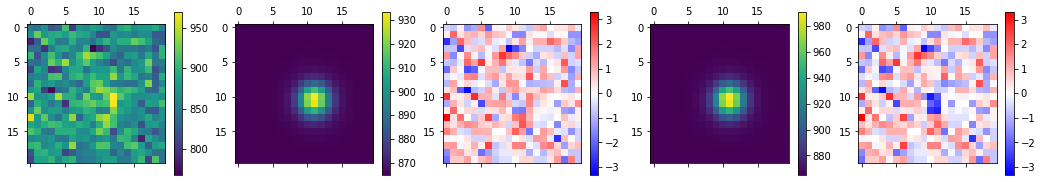

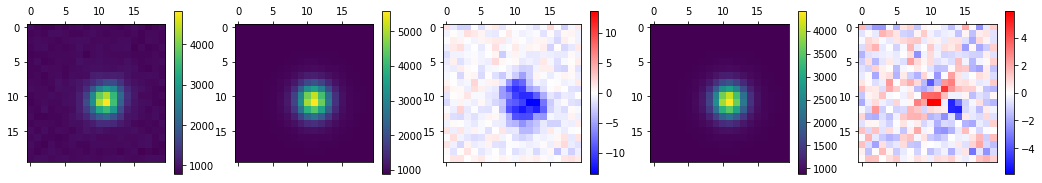

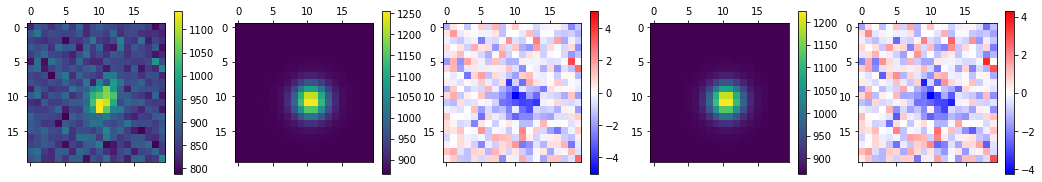

In [259]:
import pytorch_lightning as pl
pl.seed_everything(2323)

for i in range(10): 
    plot_flux_residuals()

# Check residuals on simulated images

In [235]:
from bliss.datasets import simulated

In [308]:
pl.seed_everything(112)

Global seed set to 112


112

In [309]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)
test_dataloader = dataset.test_dataloader()

In [310]:
for _, test_batch in enumerate(test_dataloader):
    break

In [311]:
# get estimates
with torch.no_grad(): 
    out = flux_encoder(test_batch['images'])
    
    tile_est_params = sleep_net.tile_images_map_estimate(test_batch['images'])
    
# reconstruction from sleep-net 
loss1, recon = flux_encoder.kl_qp_flux_loss(test_batch,
                                             tile_est_params['fluxes'], 
                                             tile_est_params['fluxes'] * 0. + 1)    
print(loss1.mean())

# get reconstruction from new encoder
loss2, recon2 = flux_encoder.kl_qp_flux_loss(test_batch,
                                             out['mean'], 
                                             out['sd'] * 0 + 1)
print(loss2.mean())

tensor(38463.4414, device='cuda:0')
tensor(37735.8984, device='cuda:0')


In [312]:
# get true parameters
_true_tile_dict = dict(locs = test_batch['locs'],
                       n_sources = test_batch['n_sources'],
                       galaxy_bool = test_batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


In [313]:
def plot_residuals(obs, recon, ax): 
    
    res = get_residuals(obs, recon)
    
    vmax = res.abs().max()
    
    im = ax.matshow(res, 
               vmax = vmax, 
               vmin = -vmax, 
               cmap = plt.get_cmap('bwr'))
    
    return im

In [314]:
import sys
sys.path.insert(0, '../flux_module/')
import plotting_utils

def plot_params(params, indx, ax): 
    locs = params['locs'][indx].cpu() * dataset.image_decoder.slen + \
                dataset.image_decoder.border_padding - 0.5
    
    locs = locs[:, (1, 0)]

    n_sources = int(params['n_sources'][indx])
    galaxy_bool = params['galaxy_bool'][indx].squeeze(-1).cpu()    
    
    plotting_utils.plot_locations(locs, 
                                  galaxy_bool, 
                                  n = n_sources, 
                                  ax = ax)

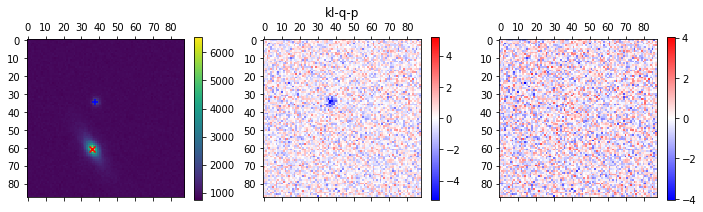

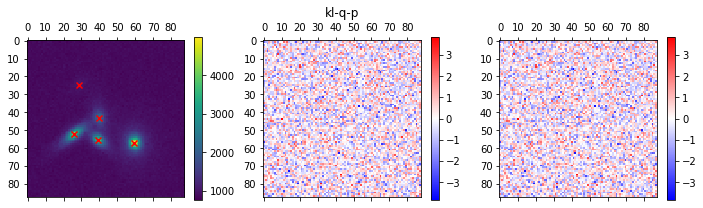

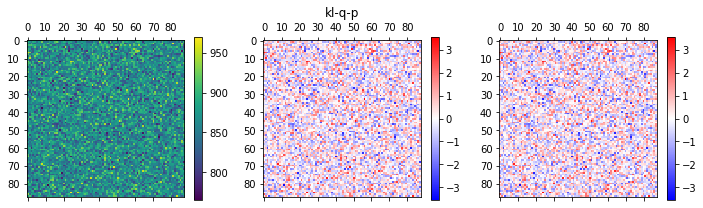

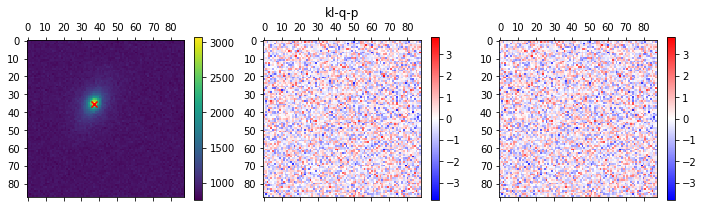

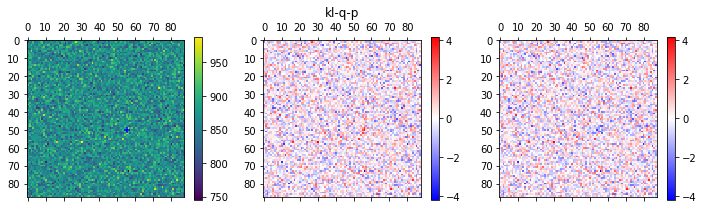

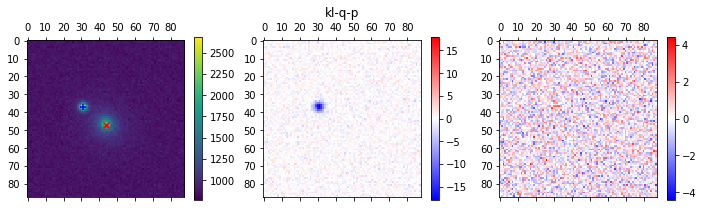

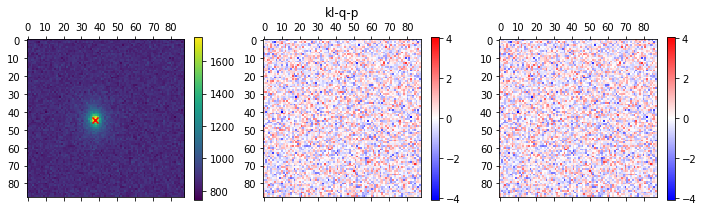

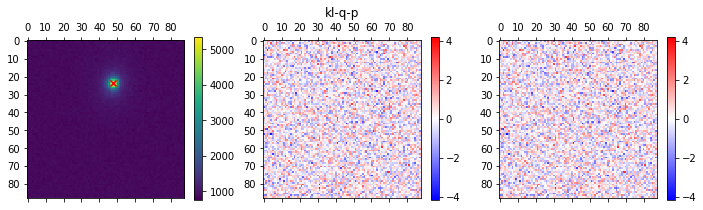

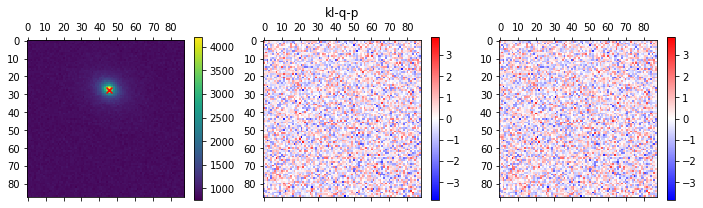

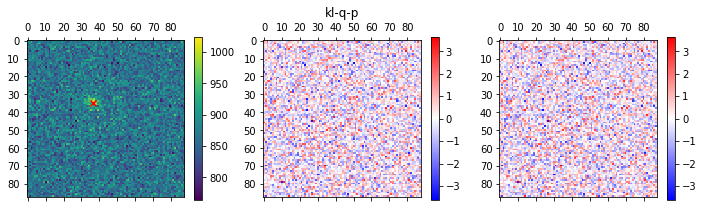

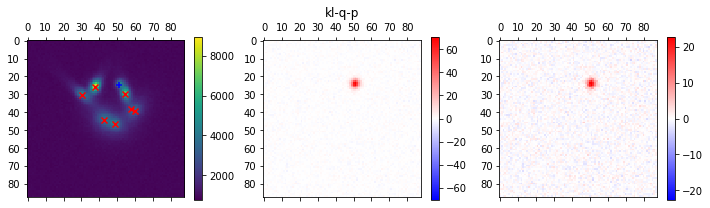

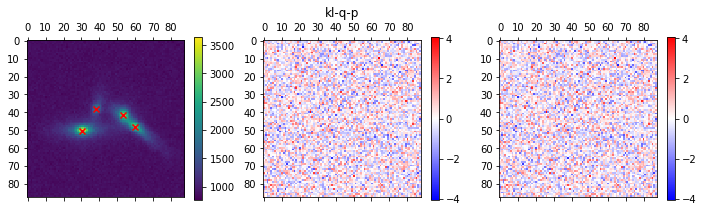

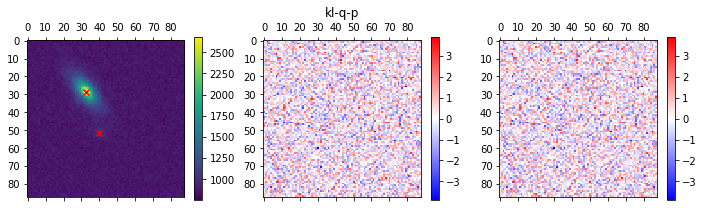

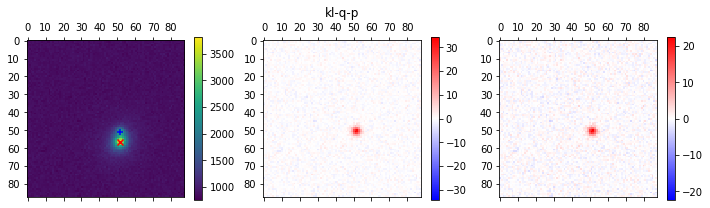

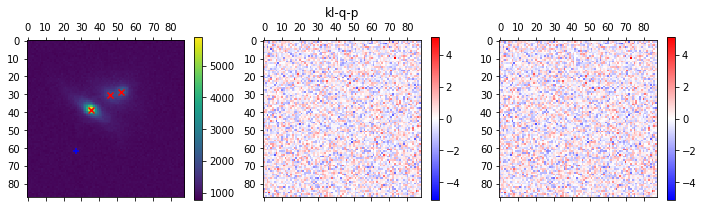

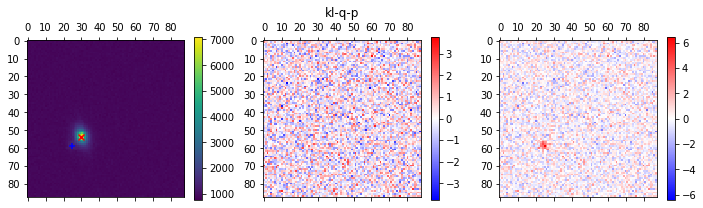

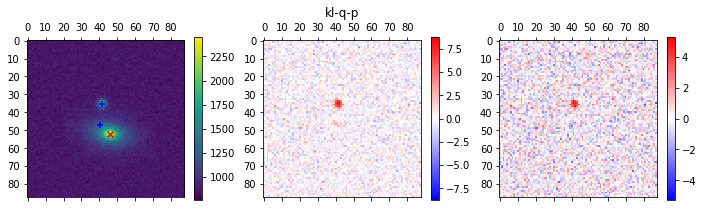

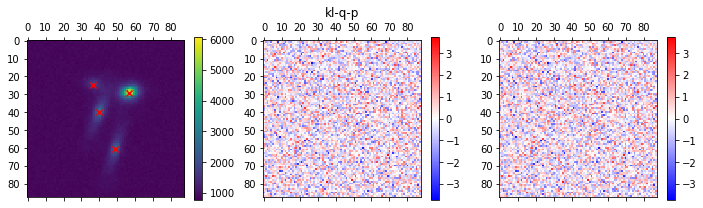

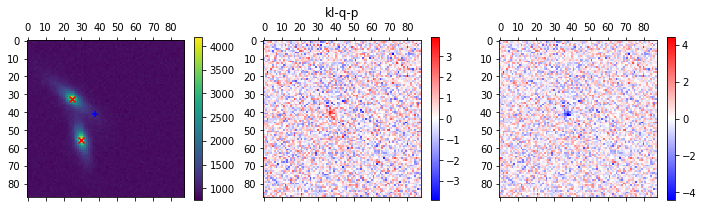

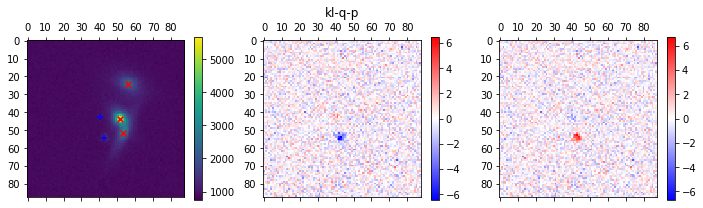

In [315]:
for i in range(20): 
    # plot observed 
    fig, axes = plt.subplots(1, 3, figsize=(12,3))  
    
    obs = test_batch['images'][i, 0].cpu()    
    im0 = axes[0].matshow(obs)
    fig.colorbar(im0, ax = axes[0])
    
    # residuals from sleepnet
    im1 = plot_residuals(obs, recon[i, 0].cpu(), axes[1])
    fig.colorbar(im1, ax = axes[1])
    axes[1].set_title('log-normal vi')
    
    
    # residuals from new encoder 
    im2 = plot_residuals(obs, recon2[i, 0].cpu(), axes[2])
    fig.colorbar(im2, ax = axes[2])
    axes[1].set_title('kl-q-p')
    
    # plot locations 
    plot_params(true_params, i, axes[0])